<a href="https://colab.research.google.com/github/OpenSynth-energy/OpenSynth/blob/Google-Colab-Notebooks/notebooks/faraday/Training_Generative_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faraday

This tutorial explains how Faraday works and how to use Faraday to train a generative model and generate synthetic smart meter data.

---

Faraday is a Conditional Variational Auto-Encoder (VAE)-based model. Unlike traditional VAEs where seeds are drawn from a normal distribution and decoded, Faraday works by:

1. First train a VAE using the following loss functions: a. MMD instead of KL-divergence b. Quantile losses and c. Mean squared error
2. Encode real samples to the latent space using the encoder, and fit a Gaussian Mixture Model (GMM) over the latent space.
3. During inference, draw samples from the GMM and decode with the decoder.

For more information on Faraday's architecture, refer to the [Faraday paper](https://arxiv.org/abs/2404.04314).

If you haven't already, please download LCL dataset from data.london.gov.uk, and follow the steps to preprocess LCL data on [OpenSynth's Github Repo](https://github.com/OpenSynth-energy/OpenSynth?tab=readme-ov-file#available-cli-apps).

**For LF Energy Summit 2024 OpenSynth Workshop only**

Preprocessed data is uploaded to google drive at: https://drive.google.com/drive/u/0/folders/1RJV-OFgeIPwWVYkTK6YPQ2TSwu4LVreN.

**Remember:**
1. Set your runtime type to GPU when running the codes for training VAE module for accelerated compute!
2. Please download your model artefacts when you've finished training before switching runtimes.

# 1️⃣ Setting up Google Colab Notebook

## Downloading Data from Google Drive

In [ ]:
folder_id = '1RJV-OFgeIPwWVYkTK6YPQ2TSwu4LVreN'
download_url = f'https://drive.google.com/drive/folders/{folder_id}?usp=sharing'
!gdown --folder {folder_id}

Retrieving folder contents
Retrieving folder 1FwTdgvxBMxk-07TO_cX21bGKkZ442jGT future
Retrieving folder 1ZLsegMZ3I5mtOWG03A2Nqt46-9WKl5Tv holdout
Processing file 1XTa-U4Zt50GXI4hVnWQhX_CJ3wAPuL-J lcl_data.csv
Processing file 1nyiaNp53cVYtbMs8IwLKm0bcw3EM8VRG mean_std.csv
Processing file 1mgVnDDD_FEZMjyhldphtpH9aMyFnsqKy outliers.csv
Retrieving folder 1y406pRAs5vNIL41Zvkdg4ZvpkxFHBE8i train
Processing file 1ThmN3pxO3AMcrtSDXesAQq_mloShuLtO lcl_data.csv
Processing file 1eMG-GiBgPUPhO1J_WaFNaSfnaK2wVOsf mean_std.csv
Processing file 19K03364jpwbRkFEH0lFYC3TNCW7dtCcI outliers.csv
Retrieving folder 1oHMynwmBJc4XiWzu23t4Np6Um5DxOKkY historical
Retrieving folder 1_QsWkR6cDsRJG-ZCyWNdOULVrZNDfSW5 holdout
Processing file 1R0vRNWAjn7pWZjwFmL4myhxu7QEG4Gbt lcl_data.csv
Processing file 1Xb6XOYPCwgDtHJOG1kSL186diUWjTYIn mean_std.csv
Processing file 1q19zJD_zpRoNiOSONk1Gvx2BaVKqdrwO outliers.csv
Retrieving folder 12oI5_JZFXLxqHlTFbqv2re_9fXy-Mu0e train
Processing file 1SO3aEMwdzzTtn-1r29nsZd4Hk5_QxZO

## Setting up Environment

### Upgrading/ installing default google colab libraries

In [ ]:
!pip install wget==3.2
!pip install opacus==1.5.2
!pip install seaborn==0.13.2

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a273b1c72b37fcb0fd814c892eb5168bf34617099e5ed357f040e5f7cc668cf5
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [ ]:
# Restart run time to make sure new versions of libraries are loaded
import os
os._exit(00)

In [ ]:
import seaborn as sns
assert sns.__version__ == '0.13.2'

### Installing OpenSynth Repository

In [ ]:
!pip install opensynth-energy==0.0.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 58.0 MB/s eta 0:00:00


# 2️⃣ Training Generative Model

In [ ]:
!ls

processed  sample_data


In [ ]:
import os
import sys
import logging

from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

data_path = Path("processed/historical/train/lcl_data.csv")
stats_path = Path("processed/historical/train/mean_std.csv")
outlier_path = Path("processed/historical/train/outliers.csv")

N_SAMPLES = 20000 # Dataset size

## 💿 Loading LCL Data

In [ ]:
# Data Modules without Outliers
dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=N_SAMPLES)
dm.setup()

In [ ]:
# Data Modules with Outliers
dm_with_outliers = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=N_SAMPLES, outlier_path=outlier_path)
dm_with_outliers.setup()

## 🏋️ Training Faraday model

In [ ]:
import torch
import pytorch_lightning as pl
torch.cuda.is_available()

True

In [ ]:
from opensynth.models.faraday.model import FaradayVAE


# List of tuneable hyperparameters:
# mse_weight: weights for MSE loss
# list all weights
model = FaradayVAE(class_dim=2, latent_dim=16, learning_rate=0.001, mse_weight=3)

### Training the VAE Module

In [ ]:
trainer = pl.Trainer(max_epochs=250, accelerator="auto")
trainer.fit(model, dm_with_outliers)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | encoder        | Encoder                 | 201 K  | train
1 | decoder        | Decoder                 | 200 K  | train
2 | reparametriser | ReparametrisationModule | 544    | train
-------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

### Training the GMM Module

In [ ]:
from opensynth.models.faraday.model import FaradayVAE, FaradayModel
model = FaradayVAE.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=249-step=25000.ckpt", map_location=torch.device("cpu"))

In [ ]:
faraday_model_1500 = FaradayModel(vae_module=model, n_components=1500, max_iter=100, tol=1e-2)
faraday_model_150 = FaradayModel(vae_module=model, n_components=150, max_iter=100, tol=1e-2)
faraday_model_50 = FaradayModel(vae_module=model, n_components=50, max_iter=100, tol=1e-2)
faraday_model_10 = FaradayModel(vae_module=model, n_components=10, max_iter=100, tol=1e-2)
faraday_model_1 = FaradayModel(vae_module=model, n_components=1, max_iter=100, tol=1e-2)

In [ ]:
gmm_data_module = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000, outlier_path=outlier_path)
gmm_data_module.setup()

In [ ]:
faraday_model_1500.train_gmm(dm=gmm_data_module)

10it [04:57, 29.77s/it]


In [ ]:
faraday_model_150.train_gmm(dm=gmm_data_module)

10it [00:57,  5.74s/it]


In [ ]:
faraday_model_50.train_gmm(dm=gmm_data_module)

10it [00:27,  2.70s/it]


In [ ]:
faraday_model_10.train_gmm(dm=gmm_data_module)

10it [00:06,  1.46it/s]


In [ ]:
faraday_model_1.train_gmm(dm=gmm_data_module)

10it [00:02,  3.73it/s]


In [ ]:
torch.save(faraday_model_1500, "faraday_model_1500.pt")
torch.save(faraday_model_150, "faraday_model_150.pt")
torch.save(faraday_model_50, "faraday_model_50.pt")
torch.save(faraday_model_10, "faraday_model_10.pt")
torch.save(faraday_model_1, "faraday_model_1.pt")

# ⚖️ Comparing results

In [ ]:
faraday_model_1500 = torch.load("faraday_model_1500.pt", weights_only=False)
faraday_model_150 = torch.load("faraday_model_150.pt", weights_only=False)
faraday_model_50 = torch.load("faraday_model_50.pt", weights_only=False)
faraday_model_10 = torch.load("faraday_model_10.pt", weights_only=False)
faraday_model_1 = torch.load("faraday_model_1.pt", weights_only=False)

In [ ]:
def generate_synthetic_samples(model, n_samples, dm):
    gmm_samples = model.sample_gmm(n_samples)
    kwh = gmm_samples[0]
    mth = gmm_samples[1]
    dow = gmm_samples[2]
    gmm_samples = dm.reconstruct_kwh(kwh)
    gmm_samples = torch.clip(gmm_samples, min=0)
    return gmm_samples


gmm_1500 = generate_synthetic_samples(faraday_model_1500, 20000, dm)
gmm_150 = generate_synthetic_samples(faraday_model_150, 20000, dm)
gmm_50 = generate_synthetic_samples(faraday_model_50, 20000, dm)
gmm_10 = generate_synthetic_samples(faraday_model_10, 20000, dm)
gmm_1 = generate_synthetic_samples(faraday_model_1, 20000, dm)

In [ ]:
real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))[0])
real_kwh = torch.clip(real_kwh, min=0) # Clip min 0 to get read of negative values

### Comparing Mean and Quantiles

In [ ]:
def plot_stats(real_kwh, gmm_reconstruct):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

    ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
    ax1.plot(gmm_reconstruct.mean(dim=0).detach().numpy(), label="gmm kwh")
    ax1.set_title("Mean kWh per half hour")
    ax1.set_xlabel("Settlement Periods")
    ax1.legend()

    ax2.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
    ax2.plot(gmm_reconstruct.quantile(0.95, dim=0).detach().numpy(), label="gmm kwh")
    ax2.set_title("95th Quantile kWh per half hour")
    ax2.set_xlabel("Settlement Periods")
    ax2.legend()

    ax3.plot(real_kwh.quantile(0.5, dim=0).detach().numpy(), label="real kwh")
    ax3.set_title("Median kWh per half hour")
    ax3.set_xlabel("Settlement Periods")
    ax3.plot(gmm_reconstruct.quantile(0.5, dim=0).detach().numpy(), label="gmm kwh")
    ax3.legend()

    fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

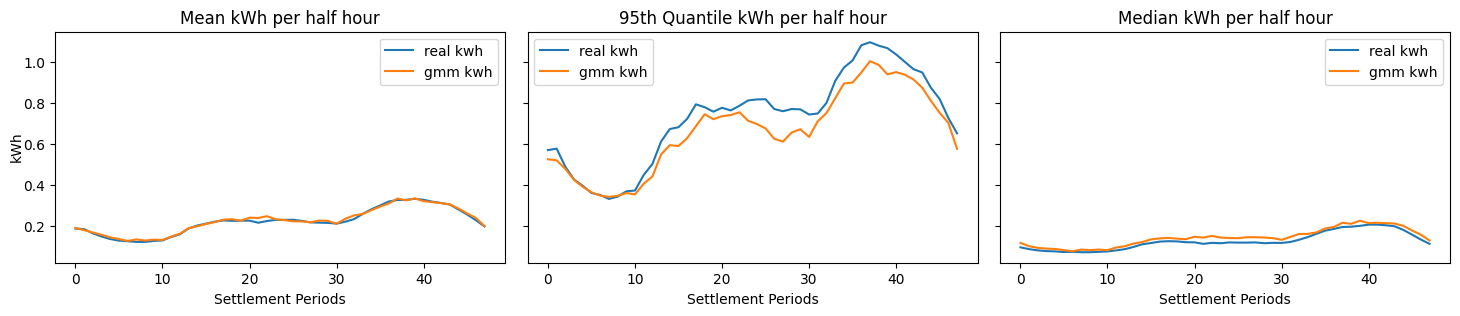

In [ ]:
plot_stats(real_kwh, gmm_1500)

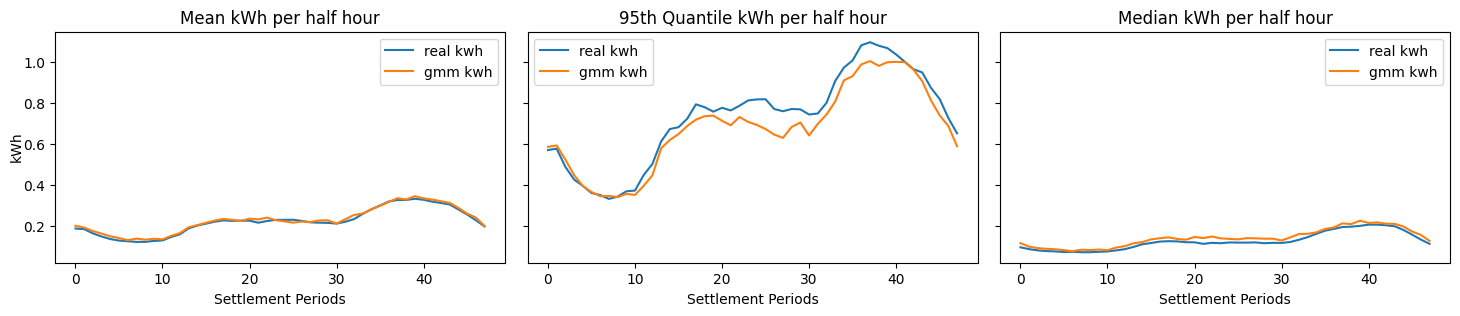

In [ ]:
plot_stats(real_kwh, gmm_150)

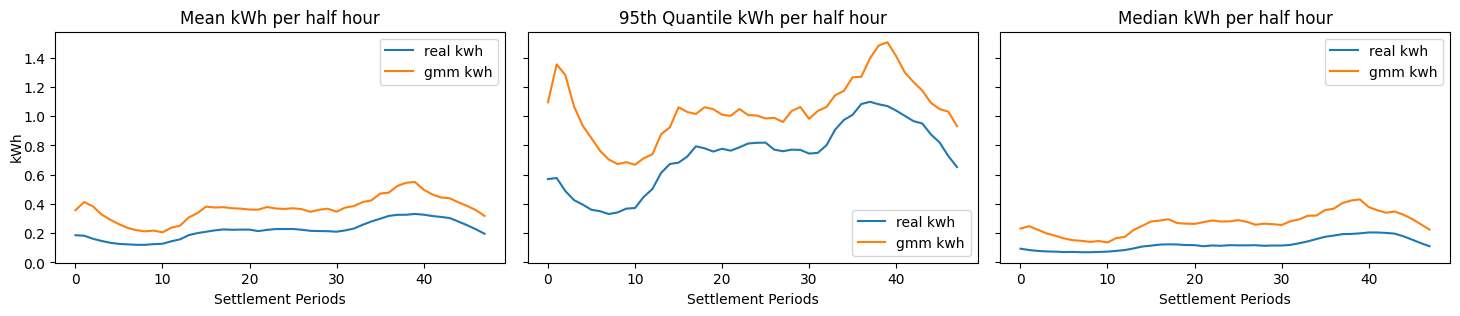

In [ ]:
plot_stats(real_kwh, gmm_1)

### Comparing TSNE and PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


def train_pca_and_tsne(real_kwh, gmm_reconstruct):
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    pca.fit(real_kwh.detach().numpy())
    pca_real = pca.transform(real_kwh.detach().numpy())
    pca_gmm = pca.transform(gmm_reconstruct.detach().numpy())

    tsne_input = np.concatenate([real_kwh.detach().numpy(), gmm_reconstruct.detach().numpy()])
    tsne_results = tsne.fit_transform(tsne_input)
    tsne_real = tsne_results[:len(real_kwh)]
    tsne_gmm = tsne_results[len(real_kwh):]

    return pca_real, pca_gmm, tsne_real, tsne_gmm


def plot_pca_tsne(pca_real, pca_gmm, tsne_real, tsne_gmm):
    fig, (ax_pca, ax_tsne) = plt.subplots(1, 2, figsize=(12, 4))

    ax_pca.scatter(pca_real[:, 0], pca_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_pca.scatter(pca_gmm[:, 0], pca_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_pca.set_title("PCA")
    ax_pca.set_xlabel("PCA 1")
    ax_pca.set_ylabel("PCA 2")
    ax_pca.legend()

    ax_tsne.scatter(tsne_real[:, 0], tsne_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_tsne.scatter(tsne_gmm[:, 0], tsne_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_tsne.set_title("TSNE")
    ax_tsne.set_xlabel("TSNE 1")
    ax_tsne.set_ylabel("TSNE 2")
    ax_tsne.legend()
    return fig

Text(0.5, 0.98, 'GMM with 1500 clusters')

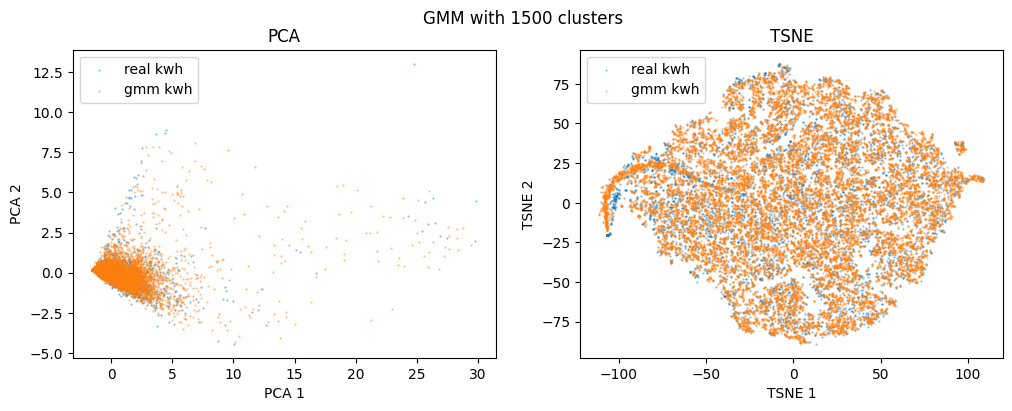

In [ ]:
a1, a2, a3, a4 = train_pca_and_tsne(real_kwh, gmm_1500)
figa = plot_pca_tsne(a1, a2, a3, a4)
figa.suptitle("GMM with 1500 clusters")

Text(0.5, 0.98, 'GMM with 150 clusters')

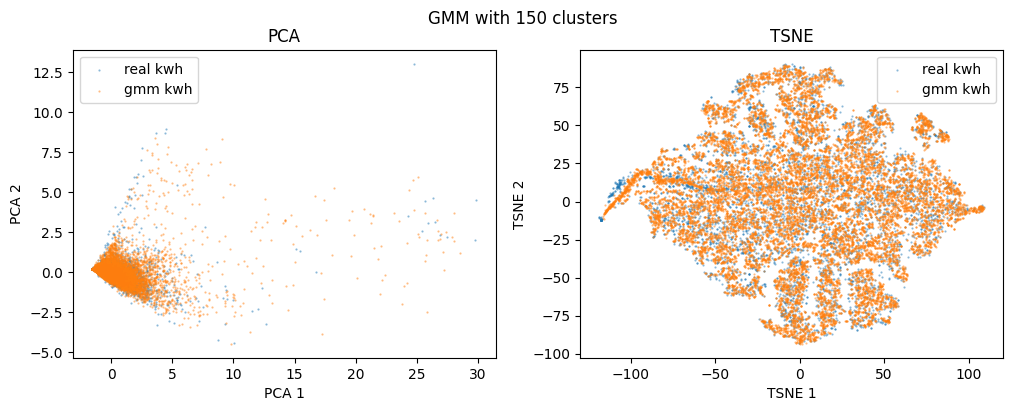

In [ ]:
b1, b2, b3, b4 = train_pca_and_tsne(real_kwh, gmm_150)
figb = plot_pca_tsne(b1, b2, b3, b4)
figb.suptitle("GMM with 150 clusters")

Text(0.5, 0.98, 'GMM with 150 clusters')

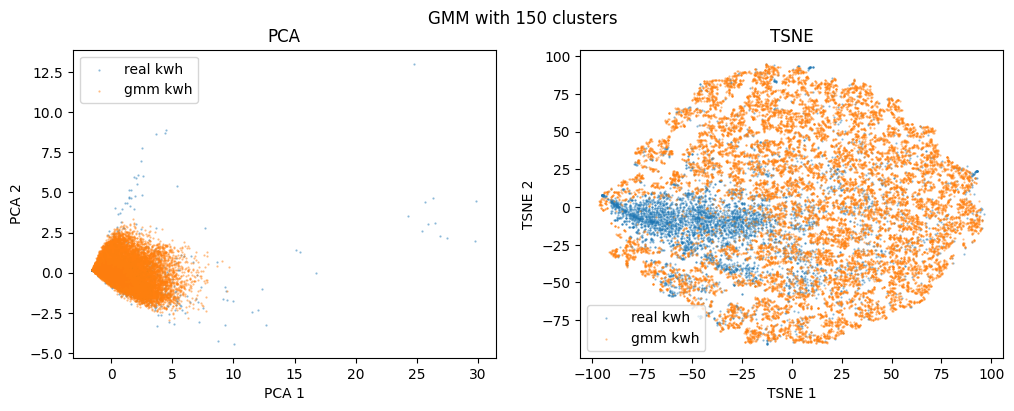

In [ ]:
c1, c2, c3, c4 = train_pca_and_tsne(real_kwh, gmm_1)
figc = plot_pca_tsne(c1, c2, c3, c4)
figc.suptitle("GMM with 150 clusters")

## 🛃 Customising your VAE Architecture


It's possible to also customise your VAE archicture without touching the rest of Faraday code. You can do this by:

1. Creating a custom class inheriting from the Encoder and Decoder module
2. Using super().__init__() to inherit all the attributes and methods of the parent class
3. Overriding the attribute encoder_layers or decoder_layers.

In this example, we'll be showing how to do this with simple linear layers, but in reality you could use more complicated architectures such as Conv1D layers, or LSTM layers. For more complex layers, you'll need to make sure that you've shaped the inputs correctly.

In [ ]:
from opensynth.models.faraday.model import FaradayVAE, Encoder, Decoder, FaradayModel
import torch.nn as nn
import torch

In [ ]:
class CustomEncoderModule(Encoder):
    """
    Custom Encoder Module
    """
    def __init__(self, latent_dim: int, input_dim: int, class_dim: int):
        """
        Inherit parent encoder attributes and methods.
        But we will be overriding the `encoder_layers` attribute
        with our custom encoder architecture.

        When inheriting from parent `Encoder` class, we need to
        pass in the attributes: latent_dim, input_dim, class_dim.

        Outputs of encoder_layers should be `latent_dim`.

        Args:
            latent_dim (int): Latent dimension.
            input_dim (int): Input dimensions.
            class_dim (int): Class dimensions.
        """
        super().__init__(latent_dim=latent_dim, input_dim=input_dim, class_dim=class_dim)
        self.encoder_layers = nn.Sequential(
            nn.Linear(self.encoder_input_dim, 1024),
            nn.GELU(),
            nn.Linear(1024, self.latent_dim)
        )

In [ ]:
class CustomDecoderModule(Decoder):
    """
    Custom Decoder Module
    """
    def __init__(self, class_dim: int, latent_dim: int, output_dim: int):
        """
        Inherit parent decoder attributes and methods.
        But we will be overriding the `decoder_layers` attribute
        with our custom decoder architecture.

        When inheriting from parent `Decoder` class, we need to
        pass in the attributes: class_dim, latent_dim, output_dim.

        Outputs of encoder_layers should be `output_dim`.

        Args:
            latent_dim (int): Latent dimension.
            output_dim (int): Output dimensions.
            class_dim (int): Class dimensions.
        """
        super().__init__(class_dim=class_dim, latent_dim=latent_dim, output_dim=output_dim)
        self.decoder_layers = nn.Sequential(
            nn.Linear(self.latent_dim, 1024),
            nn.GELU(),
            nn.Linear(1024, self.output_dim)
        )

In [ ]:
custom_encoder = CustomEncoderModule(class_dim=2, latent_dim=16, input_dim=48)
custom_decoder = CustomDecoderModule(class_dim=2, latent_dim=16, output_dim=48)

faraday_custom_vae = FaradayVAE(
    class_dim=2,
    latent_dim=16,
    learning_rate=0.001,
    mse_weight=3,
    custom_encoder=custom_encoder,
    custom_decoder=custom_decoder
)

custom_trainer = pl.Trainer(max_epochs=250, accelerator="auto")
custom_trainer.fit(faraday_custom_vae, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | encoder        | CustomEncoderModule     | 68.6 K | train
1 | decoder        | CustomDecoderModule     | 66.9 K | train
2 | reparametriser | ReparametrisationModule | 544    | train
-------------------------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=250` reached.


In [ ]:
faraday_custom_model = FaradayModel(vae_module=faraday_custom_vae, n_components=5, max_iter=100, tol=1e-2)
gmm_data_module = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000)
gmm_data_module.setup()
faraday_custom_model.train_gmm(dm=gmm_data_module)


0it [00:00, ?it/s]
1it [00:00,  2.95it/s]
2it [00:00,  3.69it/s]
3it [00:00,  3.73it/s]
4it [00:01,  4.07it/s]
5it [00:01,  4.21it/s]
6it [00:01,  4.12it/s]
7it [00:01,  4.27it/s]
8it [00:01,  4.29it/s]
9it [00:02,  4.48it/s]
10it [00:02,  4.24it/s]


In [ ]:
custom_gmm_samples = faraday_custom_model.sample_gmm(n_samples=10000)

custom_gmm_kwh = custom_gmm_samples[0]
custom_gmm_mth = custom_gmm_samples[1]
custom_gmm_dow = custom_gmm_samples[2]
custom_gmm_reconstruct = dm.reconstruct_kwh(custom_gmm_kwh)
custom_gmm_resconstruct = torch.clip(custom_gmm_reconstruct, min=0)

custom_real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))[0])
custom_real_kwh = torch.clip(custom_real_kwh, min=0) # Clip min 0 to get read of negative values

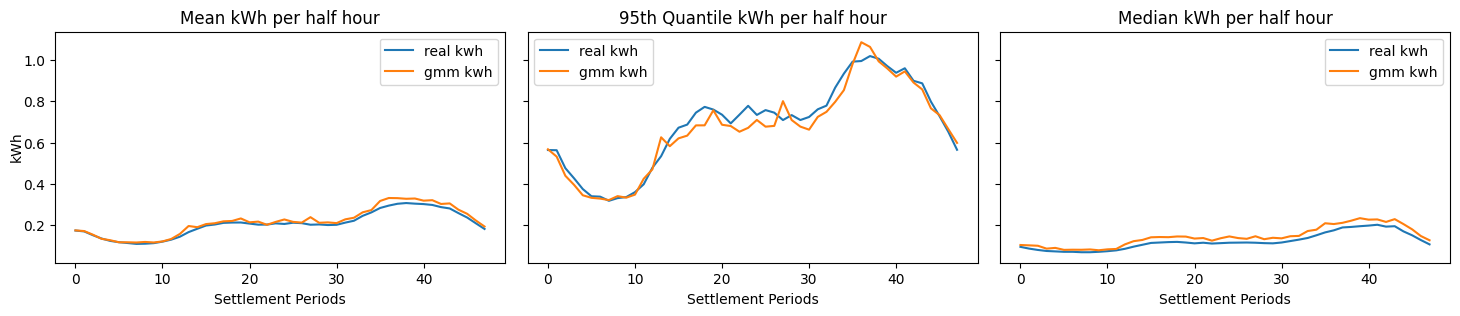

In [ ]:
plot_stats(custom_real_kwh, custom_gmm_resconstruct)

Text(0.5, 0.98, 'Custom VAE')

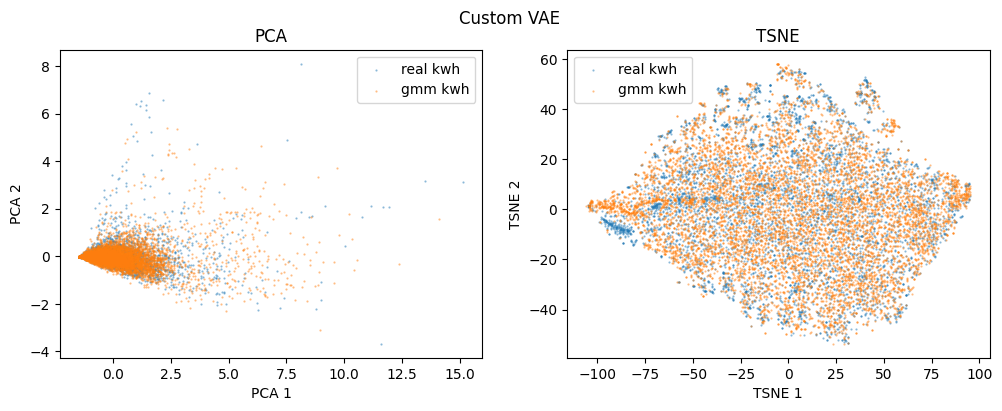

In [ ]:
d1,d2,d3,d4 = train_pca_and_tsne(custom_real_kwh, custom_gmm_resconstruct)
figd = plot_pca_tsne(d1,d2,d3,d4)
figd.suptitle("Custom VAE")

# 🤫 Training with Differential Privacy

Privacy should be one of the concerns with genarating synthetic data, especially when done for data sharing purposes. To implement privacy, we use Differentially-Private Stochastic Gradient Descent [[1]](https://arxiv.org/abs/1607.00133) implemented with Pytorch Opacus library [[2]](https://opacus.ai/).

You can train Faraday with Differential Privacy turned on with the differential_privacy parameter as demonstrated below. When implementing DP-SGD, you need to specify the following:

- epsilon - the level of privacy (high epsilon = less private)
- delta - this should be $\frac{1}{N}$, where $N$ is the size of the dataset

For more context and considerations between Privacy and synthetic smart meter generation, e.g. on deciding epsilon value, check out this paper from Centre for Net Zero: [Defining "Good": Evalution Framework for SYnthetic Smart Meter Data](https://arxiv.org/abs/2407.11785).

In [ ]:
from opensynth.models.faraday.model import FaradayVAE

vae_dp = FaradayVAE(
    class_dim=2,
    latent_dim=16,
    learning_rate=0.001,
    mse_weight=3,
    differential_privacy=True,
    epsilon=8.0,
    delta=1/20000,
)

# Note: only training for 25 epochs for demo purposes as this is computationally very expensive
dp_trainer = pl.Trainer(max_epochs=25, accelerator="auto")
dp_trainer.fit(vae_dp, dm)

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                    | Params | Mode 
-------------------

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
